# MDI 3434 - Challenge Large Scale Machine Learning

**Réalisation** : *Mathieu Bruniquel*

## Utilitaires & Imports

### Imports

In [61]:
import sys
import numpy as np 
import pandas as pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, FeaturesData
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

### Confusion Matrix Plot function

In [2]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Data Exploration

In [3]:
# Loading datasets
y_train = pd.read_csv('ytrain_challenge.csv')
x_train = pd.read_csv('xtrain_challenge.csv')
df_train = pd.concat([x_train, y_train], axis=1)

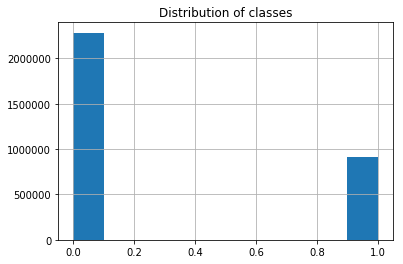

In [4]:
# Plotting distribution of classes
y_train.hist()
plt.title("Distribution of classes")
plt.show()

In [5]:
# Computing proportions of classes in the training dataset
prop_class0 = y_train[y_train['y']==0].shape[0]/y_train.shape[0]
prop_class1 = y_train[y_train['y']==1].shape[0]/y_train.shape[0]
print("Proportion of class 0 in the training set : {}".format(prop_class0))
print("Proportion of class 1 in the training set : {}".format(prop_class1))

Proportion of class 0 in the training set : 0.7142652899374778
Proportion of class 1 in the training set : 0.2857347100625222


**Classes are not balanced in the training set : there are more instances with label 0 than label 1.**

**Before proceeding to further data analysis and exploration, we'll work with a subset of the original dataset in order to fasten computationnal time**

In [6]:
# Creating a random subset of original dataset in order to fasten data exploration
df_sub = df_train.sample(n=x_train.shape[0]//1000)

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


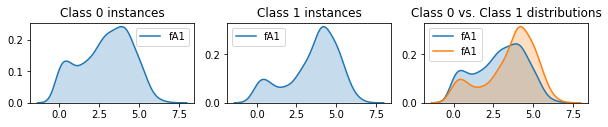

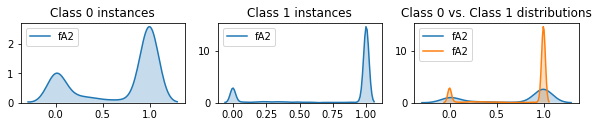

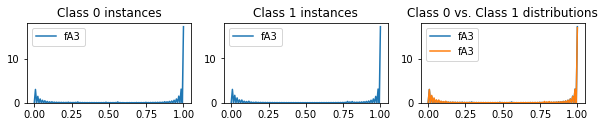

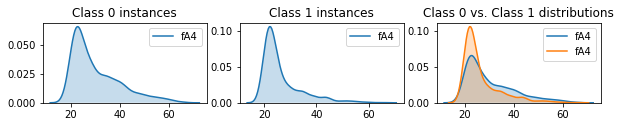

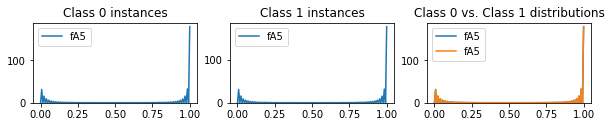

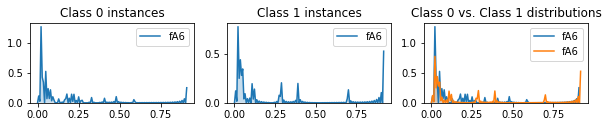

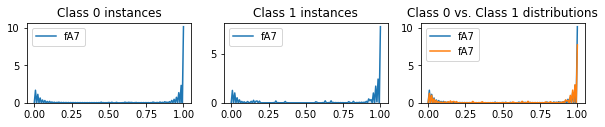

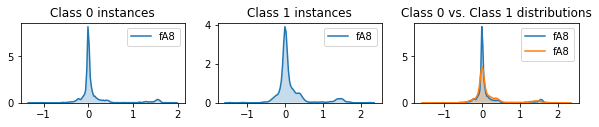

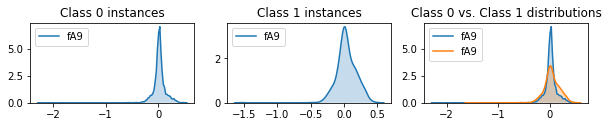

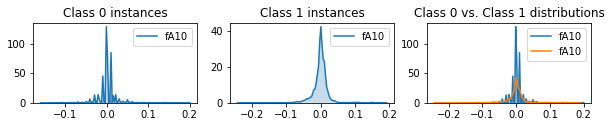

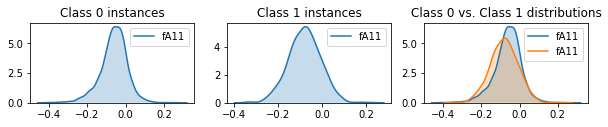

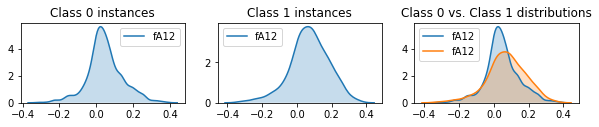

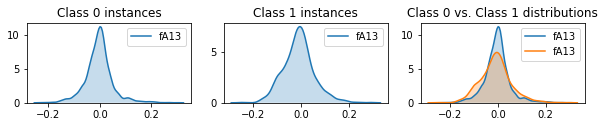

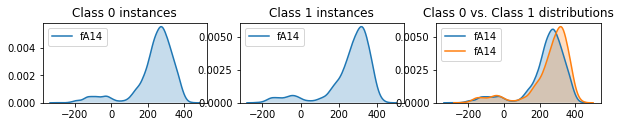

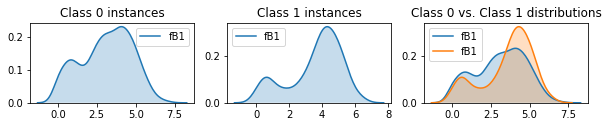

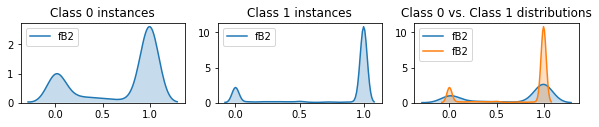

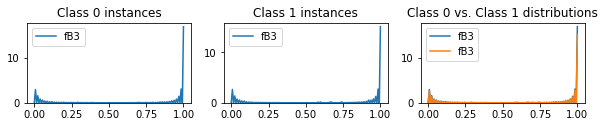

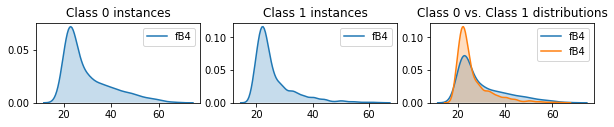

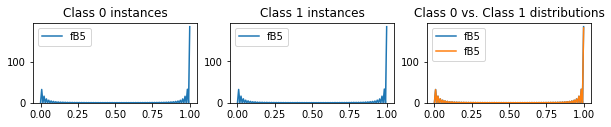

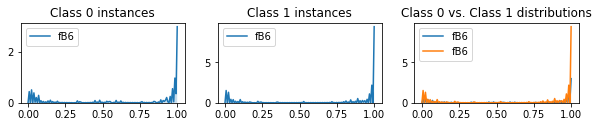

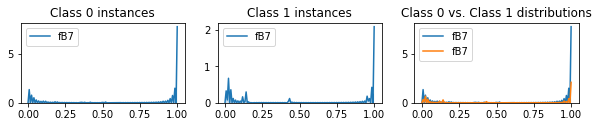

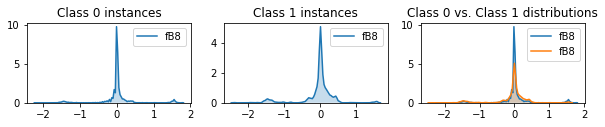

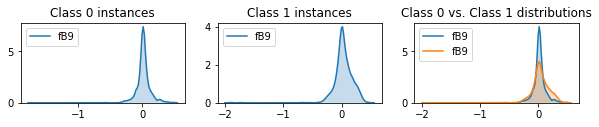

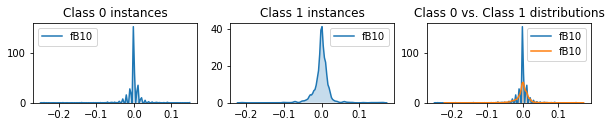

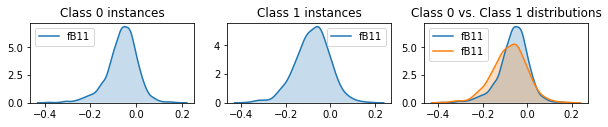

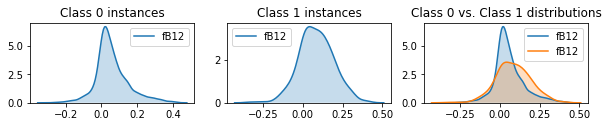

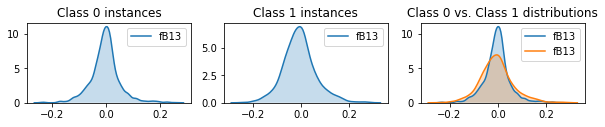

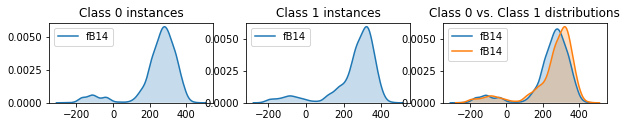

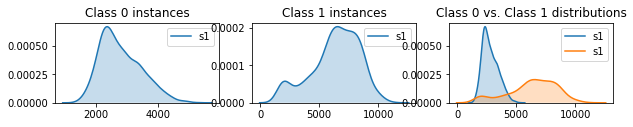

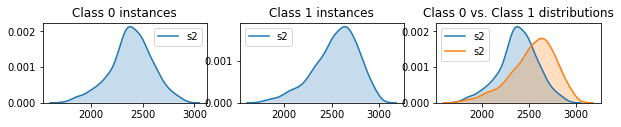

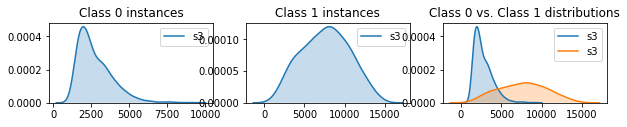

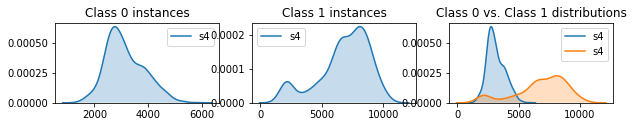

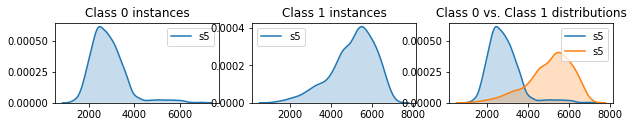

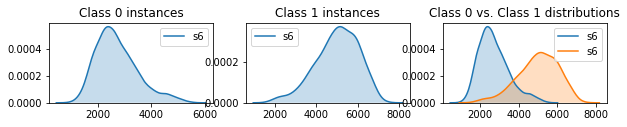

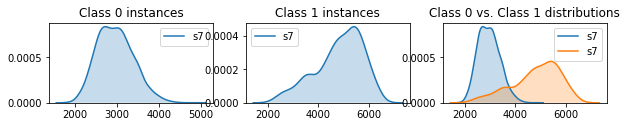

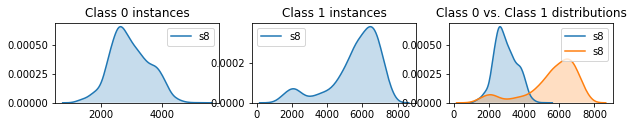

In [7]:
# Plotting distribution of data
for col in list(df_sub.columns)[:-1]:
    plt.figure(figsize=(10,5))
    plt.subplot(331)
    plt.title("Class 0 instances")
    sns.kdeplot(df_sub[df_sub['y']==0][col], shade=True)

    plt.subplot(332)
    plt.title("Class 1 instances")
    sns.kdeplot(df_sub[df_sub['y']==1][col], shade=True)
    
    plt.subplot(333)
    plt.title("Class 0 vs. Class 1 distributions")
    sns.kdeplot(df_sub[df_sub['y']==0][col], shade=True)
    sns.kdeplot(df_sub[df_sub['y']==1][col], shade=True)

**It can be noticed that for some features, in particular s1 to s8, classes overlap less than for features fA1 to fB14, which makes sense as the latest are caracheristics of images taken independently, whereas features S1 to S8 are indicators of similarity between images. It can be guessed that these features will play an important part when training classifiers**

## Modelisation - First attempts

As a first step, several models will be tested with moderate complexity in order to rapidly picture how each of them performs and how they could be used and tuned afterwards for final predictions

### Data

In [8]:
# Fitting first model on 5% of the data in order to increase computation time
df_sub2 = df_train.sample(n=df_train.shape[0]//20)

In [9]:
# Splitting the dataset into training and testing sets
train, test = train_test_split(df_sub2, test_size=0.2)

In [10]:
xtrain = train.drop(columns=['y'])
xtest = test.drop(columns=['y'])
ytrain = train['y']
ytest = test['y']

### Ensemble Learning :  Random Forests & extra Trees

#### Random Forest

Test Score of random forest : 0.9778194900672611


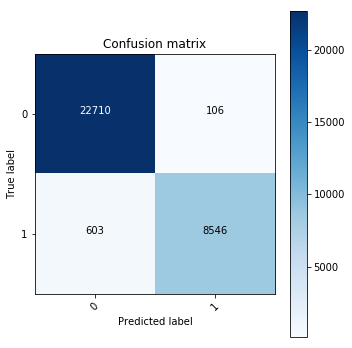

In [11]:
rf1 = RandomForestClassifier(n_estimators=10)
rf1.fit(xtrain, ytrain)


y_pred_rf = rf1.predict(xtest)
print("Test Score of random forest : {}".format(rf1.score(xtest, ytest)))

cm_log_rf = confusion_matrix(ytest, y_pred_rf)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_log_rf, classes=np.sort(ytest.unique()),
                      title='Confusion matrix')

#### Extra Trees

Test Score of extra trees: 0.9765055529485375


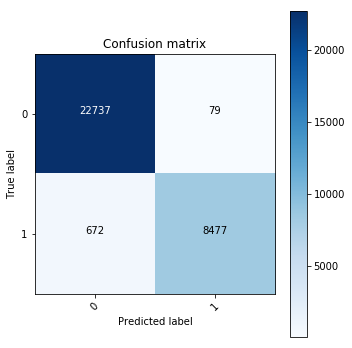

In [12]:
eT1 = ExtraTreesClassifier(n_estimators=10)
eT1.fit(xtrain, ytrain)


y_pred_eT = eT1.predict(xtest)
print("Test Score of extra trees: {}".format(eT1.score(xtest, ytest)))

cm_log_eT = confusion_matrix(ytest, y_pred_eT)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_log_eT, classes=np.sort(ytest.unique()),
                      title='Confusion matrix')

**It appears that xtree models perform better at predicting class 0 than the random forest ones.
On the other hand, random Forests seem to perform better at finding class 1 observations**

### Boosting Method


#### XGBoost

Test Score of XGBoost: 0.9631159080244017


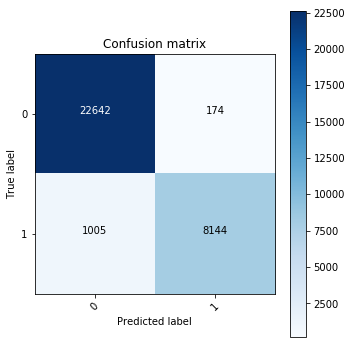

In [68]:
xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=10, njobs=-1)
xgb.fit(xtrain, ytrain)


y_pred_xgb = xgb.predict(xtest)
print("Test Score of XGBoost: {}".format(accuracy_score(ytest, y_pred_xgb)))

cm_log_xgb = confusion_matrix(ytest, y_pred_xgb)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_log_xgb, classes=np.sort(ytest.unique()),
                      title='Confusion matrix')

It can be said that all these models perform already well on a single train-test split. 
The next step is to understand why these models misclassify some points and find if transformation of the data might be of any help.
Finally I will try to improve their performances by hyperparameter tuning using cross validation

## Focusing on where misclassification occurs

As all classifiers tested above seem to make the same kind of mistakes (based on their confusion matrix), let's see how are distributed the errors made by only one of them (say the extra tree model)

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


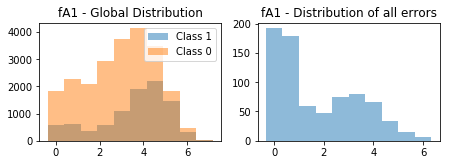

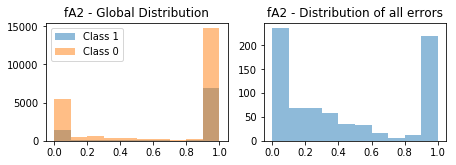

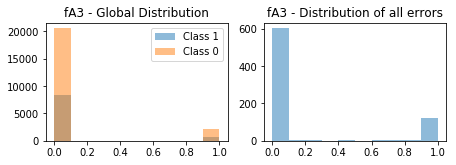

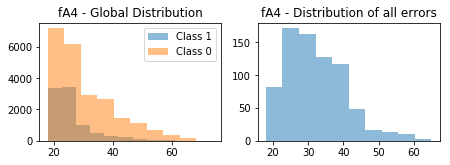

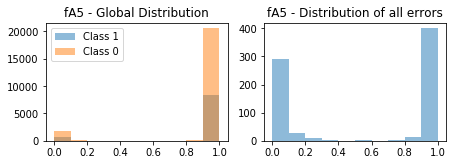

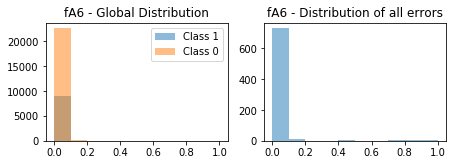

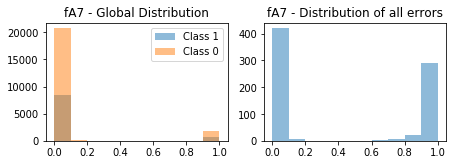

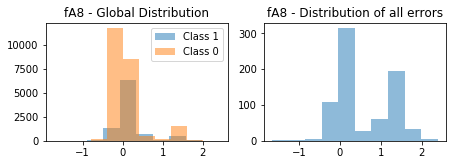

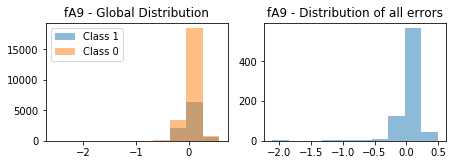

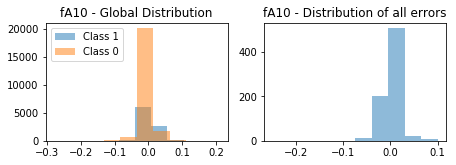

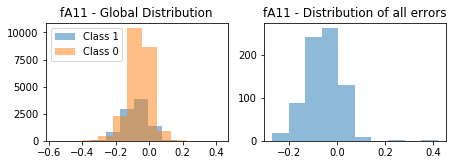

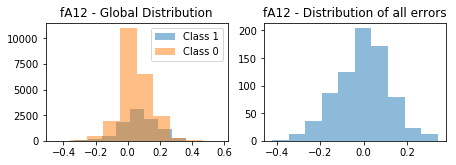

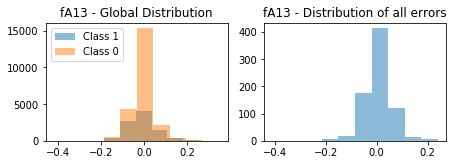

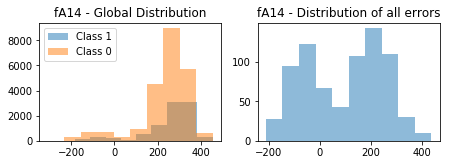

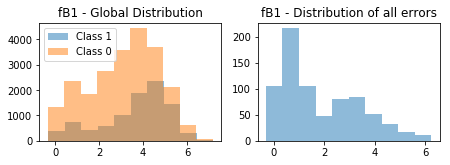

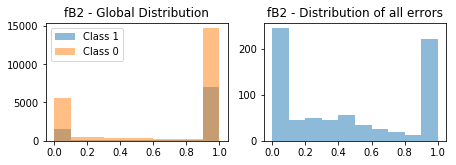

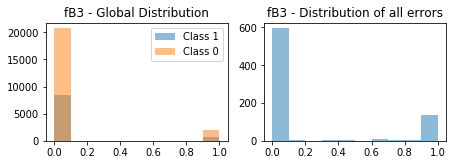

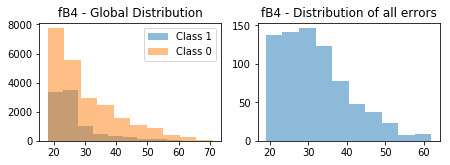

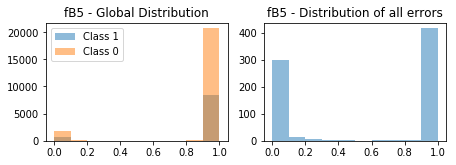

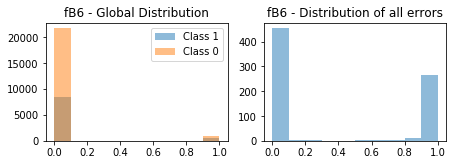

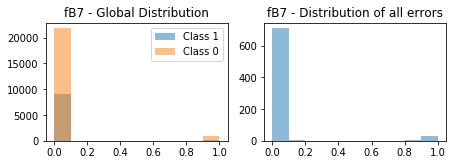

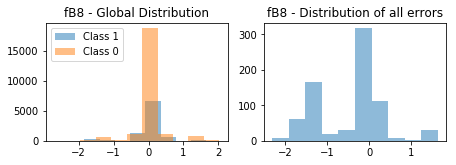

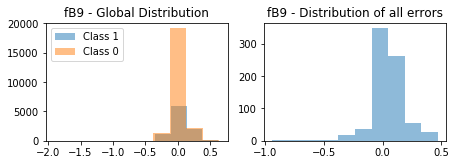

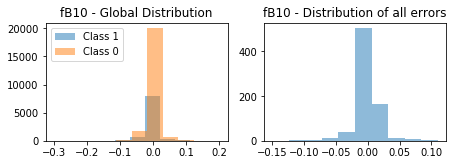

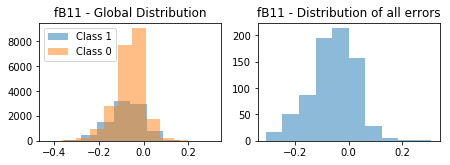

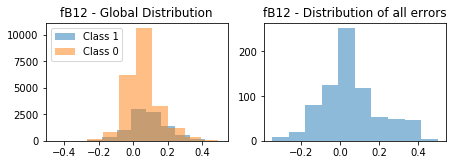

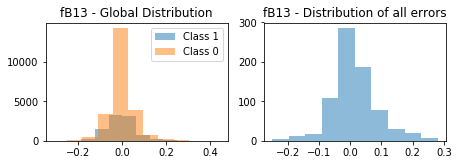

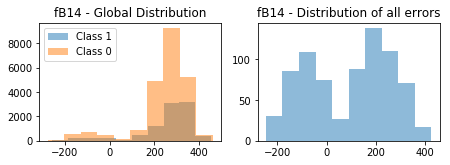

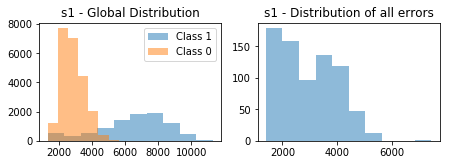

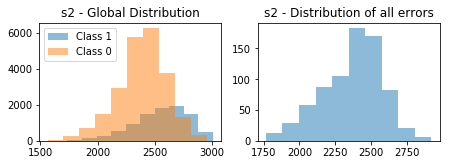

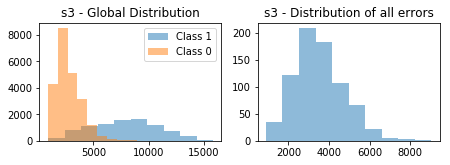

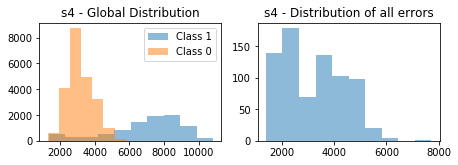

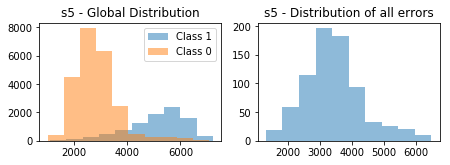

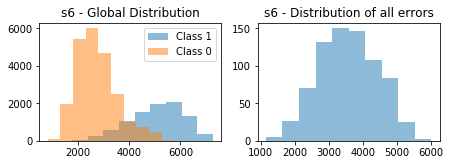

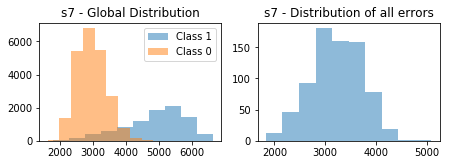

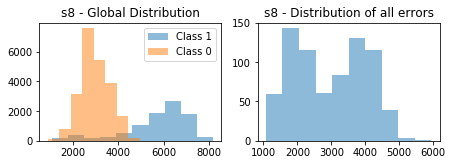

In [21]:
x_test_focus = pd.concat([xtest.reset_index(), pd.concat([ytest.reset_index(),pd.DataFrame(y_pred_eT)], axis=1)], axis=1)
x_test_focus = x_test_focus.drop(columns=['index'])

for col in x_test_focus.columns.tolist()[:-2]:
    plt.figure(figsize=(15,10))
    plt.subplot(441)
    plt.hist(x_test_focus[x_test_focus['y']==1][col], alpha=0.5, label='Class 1')
    plt.hist(x_test_focus[x_test_focus['y']==0][col], alpha=0.5, label='Class 0')
    plt.legend()
    plt.title(col + str(' - Global Distribution'))
    plt.subplot(442)
    plt.hist(x_test_focus[x_test_focus['y']!=x_test_focus[0]][col], alpha = 0.5, label='Predicted Error')
    plt.title(col + str(' - Distribution of all errors'))
    
plt.show()

It is striking that most misclassified instances are located in the overlapping areas of class 1 and class 0

**A solution could be to try to reduce the overlapping of data**

## Resampling the data

** From literrature, it appears that resampling methods can be used to cope with the misbalanincing and overlapping ditribution of classes**

### Undersampling

In [24]:
# Class count
count_class_0, count_class_1 = ytrain.value_counts()

# Divide by class
dftrain_class_0 = train[train['y'] == 0]
dftrain_class_1 = train[train['y'] == 1]

# Resampling class 0 dataframe with number of instances same as class 1 dafatrame
dftrain_class_0_under = dftrain_class_0.sample(count_class_1)
dftrain_undersampled = pd.concat([dftrain_class_0_under, dftrain_class_1], axis=0)

In [33]:
xtrain_under = dftrain_undersampled.drop(columns=['y'])
ytrain_under = dftrain_undersampled['y']

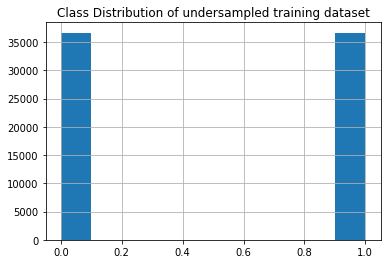

In [34]:
# Checking subsample worked and classes are balanced
ytrain_under.hist()
plt.title("Class Distribution of undersampled training dataset")
plt.show()

We have now a well-balanced dataset

### Oversampling

In [26]:
# Resampling class 0 dataframe with number of instances same as class 1 dafatrame
dftrain_class_1_over = dftrain_class_1.sample(count_class_0, replace=True)
dftrain_oversampled = pd.concat([dftrain_class_0, dftrain_class_1_over], axis=0)

In [31]:
xtrain_over = dftrain_oversampled.drop(columns=['y'])
ytrain_over = dftrain_oversampled['y']

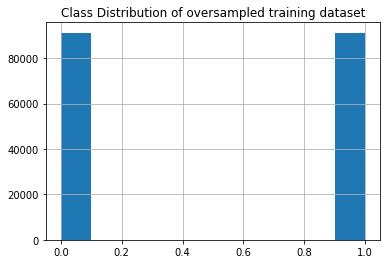

In [32]:
# Checking subsample worked and classes are balanced
ytrain_over.hist()
plt.title("Class Distribution of oversampled training dataset")
plt.show()

## Training model on sampled data

Let's try this new approach with the previous random forest classifier 

### Undersample training

Test Score of random forest : 0.9750351947442515


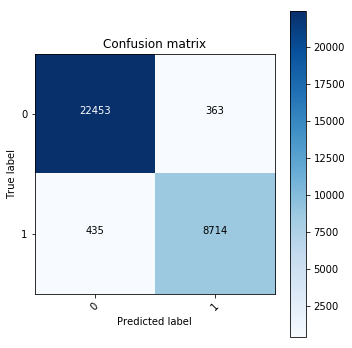

In [36]:
rf1 = RandomForestClassifier(n_estimators=10)
rf1.fit(xtrain_under, ytrain_under)


y_pred_rf_under = rf1.predict(xtest)
print("Test Score of random forest : {}".format(rf1.score(xtest, ytest)))

cm_log_rf_under = confusion_matrix(ytest, y_pred_rf_under)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_log_rf_under, classes=np.sort(ytest.unique()),
                      title='Confusion matrix')

### Oversample training

Test Score of random forest : 0.9764117002972


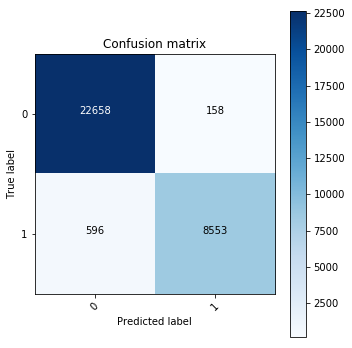

In [38]:
rf1 = RandomForestClassifier(n_estimators=10)
rf1.fit(xtrain_over, ytrain_over)


y_pred_rf_over = rf1.predict(xtest)
print("Test Score of random forest : {}".format(rf1.score(xtest, ytest)))

cm_log_rf_over = confusion_matrix(ytest, y_pred_rf_over)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_log_rf_over, classes=np.sort(ytest.unique()),
                      title='Confusion matrix')

The model performs correctly and it can be noticed that it doesn't make the same classificaiton errors than when fitted on the orginial data.
It might be interesting to to ensemble learning with these 3 models and see if it improves the score.

**Let's try some blening**

## Blending

### Original and sampled models

Score of blended random forest model : 0.9789770061004224
Score of original random forest model : 0.9778194900672611


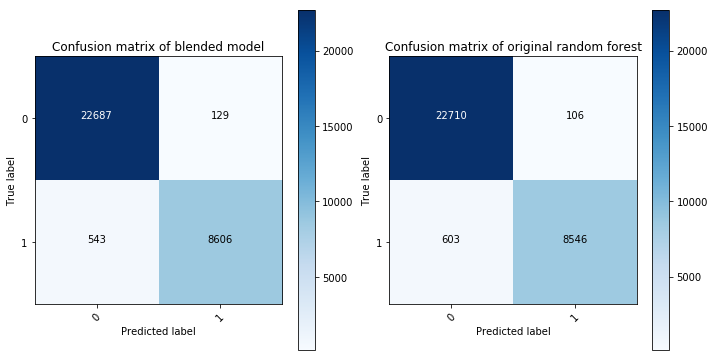

In [53]:
# Summing predictions of three models into one column
blend = np.sum([y_pred_rf, y_pred_rf_over, y_pred_rf_under], axis=0)

# Building new predictions based on majority
blend_pred = np.zeros(len(blend))
for i,x in enumerate(blend):
    if x>1:
        blend_pred[i] = 1

print("Score of blended random forest model : {}".format(accuracy_score(ytest, blend_pred)))
print("Score of original random forest model : {}".format(accuracy_score(ytest, y_pred_rf)))
        
cm_log_blend = confusion_matrix(ytest, blend_pred)

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_confusion_matrix(cm_log_blend, classes=np.sort(ytest.unique()),
                      title='Confusion matrix of blended model')
plt.subplot(222)
plot_confusion_matrix(cm_log_rf, classes=np.sort(ytest.unique()),
                      title='Confusion matrix of original random forest')

It can be said that the blending helped improve the score. This method will then be used from now on

### Different algorithms

Above, we blended models where a single algorithm was used. Let's try to do the same but using different algorithms

Score of blended algos : 0.9756921633036133


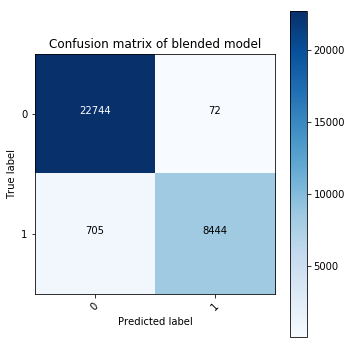

In [59]:
# Summing predictions of three original algorithms into one
blend_algo = np.sum([y_pred_rf, y_pred_eT, y_pred_xgb], axis=0)

# Building new predictions based on majority
blend_algo_pred = np.zeros(len(blend_algo))
for i,x in enumerate(blend_algo):
    if x>1:
        blend_algo_pred[i] = 1

print("Score of blended algos : {}".format(accuracy_score(ytest, blend_algo_pred)))
        
cm_log_algo_blend = confusion_matrix(ytest, blend_algo_pred)

plt.figure(figsize=(5,5))

plot_confusion_matrix(cm_log_algo_blend, classes=np.sort(ytest.unique()),
                      title='Confusion matrix of blended model')


This time, it didn't improve the score. However It seems that it makes less false negatives but more false positives than with the other method. It may be useful afterwards

## Grid Search and Cross Validation

I then decided to implement cross validation to tune hyperparameters of each model.
I performed training tasks on google collab when the complexity of models increased over 100 estimators

In [62]:
# In order not to make the cross validation process last to long, let's do it on a subsample of the data
df_sub3 = df_train.sample(n=x_train.shape[0]//10)
X = df_sub3.drop(columns=['y'])
y = df_sub3['y']

### Random Forest CV

In [93]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

criterion_range = ["gini","entropy"]
max_depth_range = [2, 3, 5, 10]
n_estimators_range = [100, 200, 500]

grid_rf = GridSearchCV(rf, param_grid={'n_estimators': n_estimators_range, 'criterion' : criterion_range, 'max_depth':max_depth_range}, cv=5)
grid_rf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [22, 24, 26, 28]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [94]:
rf_grid_results = grid_rf.cv_results_
rf_best_par = grid_rf.best_params_
print(rf_best_par)

{'criterion': 'gini', 'max_depth': 22}


After several iterations, the best parameters I obtained were :
- criterion : 'gini'
- max_depth : 3
- n_estimators = 500

### Extra Trees CV

In [101]:
eT = ExtraTreesClassifier(n_estimators=10, n_jobs=-1)

criterion_range = ["gini","entropy"]
max_depth_range = [2, 3, 5, 10]
n_estimators_range = [100, 200, 300]

grid_eT = GridSearchCV(eT, param_grid={'criterion' : criterion_range, 'max_depth':max_depth_range}, cv=5)
grid_eT.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [102]:
eT_grid_results = grid_eT.cv_results_
eT_best_par = grid_eT.best_params_
print(eT_best_par)

{'criterion': 'entropy', 'max_depth': 30}


After several iterations, the best parameters I obtained were :
- criterion : 'gini'
- max_depth : 3
- n_estimators : 500

### XGBoost CV

In [98]:
xgb = XGBClassifier(n_estimators=10, njobs=-1)

max_depth_range = [30, 50]
learning_rate_range = [0.4, 0.7, 0.9]

grid_xgB = GridSearchCV(xgb, param_grid={'learning_rate' : learning_rate_range, 'max_depth':max_depth_range}, cv=5)
grid_xgB.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, njobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.4, 0.7, 0.9], 'max_depth': [30, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [99]:
xgB_grid_results = grid_xgB.cv_results_
xgB_best_par = grid_xgB.best_params_
print(xgB_best_par)

{'learning_rate': 0.7, 'max_depth': 30}


After several iterations, the best parameters I obtained were :
- learning rate : 1
- max_depth : 4
- n_estimators : 200

## Final training, prediction and submission

### Training

In [ ]:
# Over sampling of entire training set
count_class_0, count_class_1 = pd.Series(y_train['y']).value_counts()

dftrain = pd.concat([x_train, y_train], axis=1)

In [ ]:
# Divide by class
dftrain_class_0 = dftrain[dftrain['y'] == 0]
dftrain_class_1 = dftrain[dftrain['y'] == 1]

# Undersampling
dftrain_class_0_under = dftrain_class_0.sample(count_class_1)
dftrain_undersampled = pd.concat([dftrain_class_0_under, dftrain_class_1], axis=0)
xtrain_undersampled = dftrain_undersampled.drop(columns=['y'])
ytrain_undersampled = dftrain_undersampled['y']

# Oversampling
dftrain_class_1_over = dftrain_class_1.sample(count_class_0, replace=True)
dftrain_oversampled = pd.concat([dftrain_class_0, dftrain_class_1_over], axis=0)
xtrain_oversampled = dftrain_oversampled.drop(columns=['y'])
ytrain_oversampled = dftrain_oversampled['y']

### Full original data set

In [ ]:
# Random Forest 
rf_final_1 = RandomForestClassifier(n_estimators=300, max_depth=3, criterion='gini', n_jobs=-1)
rf_final_1.fit(x_train, y_train['y']) 

In [ ]:
# Extra Trees
eT_final_1 = ExtraTreesClassifier(n_estimators=500, max_depth=3, criterion='gini', n_jobs=-1)
eT_final_1.fit(x_train, y_train['y']) 

In [ ]:
# XGBoost
xgb_final_1 = XGBClassifier(n_estimators=200, learning_rate=1,  njobs=-1)
xgb_final_1.fit(x_train, y_train['y']) 

### Full undersampled data set

In [ ]:
# Random Forest 
rf_final_2 = RandomForestClassifier(n_estimators=300, max_depth=3, criterion='gini', n_jobs=-1)
rf_final_1.fit(x_train, y_train['y']) 
rf_final_2.fit(xtrain_undersampled, ytrain_undersampled)

In [ ]:
# Extra Trees
eT_final_2 = ExtraTreesClassifier(n_estimators=500, max_depth=3, criterion='gini', n_jobs=-1)
eT_final_2.fit(xtrain_undersampled, ytrain_undersampled)

In [104]:
# XGBoost
xgb_final_2 = XGBClassifier(n_estimators=200, learning_rate=1,  njobs=-1)
xgb_final_2.fit(xtrain_undersampled, ytrain_undersampled)

NameError: name 'xtrain_undersampled' is not defined

### Full oversampled data set

In [ ]:
# Random Forest 
rf_final_2 = RandomForestClassifier(n_estimators=300, max_depth=3, criterion='gini', n_jobs=-1)
rf_final_1.fit(x_train, y_train['y']) 
rf_final_2.fit(xtrain_oversampled, ytrain_oversampled)

In [ ]:
# Extra Trees
eT_final_2 = ExtraTreesClassifier(n_estimators=500, max_depth=3, criterion='gini', n_jobs=-1)
eT_final_2.fit(xtrain_oversampled, ytrain_oversampled)

In [ ]:
## XGBoost
xgb_final_2 = XGBClassifier(n_estimators=200, learning_rate=1,  njobs=-1)
xgb_final_2.fit(xtrain_oversampled, ytrain_oversampled)

### Blending

In [ ]:
x_test = pd.read_csv('xtest_challenge.csv')

In [ ]:
y1 = rf_final_1.predict(xtest)
y2 = rf_final_2.predict(xtest)
y3 = rf_final_3.predict(xtest)

y4 = eT_final_1.predict(xtest)
y5 = eT_final_2.predict(xtest)
y6 = eT_final_3.predict(xtest)

y7 = xgb_final_1.predict(xtest)
y8 = xgb_final_2.predict(xtest)
y9 = xgb_final_3.predict(xtest)

blend = np.sum([y1, y2, y3, y4, y5, y6, y7, y8, y9], axis=0)

# Building new predictions based on majority
blend_pred = np.zeros(len(blend))
for i,x in enumerate(blend):
    if x>4:
        blend_pred[i] = 1

In [ ]:
np.savetxt('ysubmission.csv', blend_pred, fmt = '%1.0d', delimiter=',')